In [1]:
import torch
import random
import numpy as np

In [2]:
batch_size=64 # type=int# help='Batch size per GPU')
benchmark = True # help='Turn on CUDNN benchmarking')
gpu_ids=[0]# type=eval# help='IDs of GPUs to use')
lr=1e-3# type=float# help='Learning rate')
max_grad_norm=-1.# help='Max gradient norm for clipping')
num_channels=512# type=int# help='Number of channels in hidden layers')
num_levels=3# type=int# help='Number of levels in the Glow model')
num_steps=32# type=int# help='Number of steps of flow in each level')
num_epochs=100# type=int# help='Number of epochs to train')
num_samples=64# type=int# help='Number of samples at test time')
num_workers=8# type=int# help='Number of data loader threads')
resume=False# help='Resume from checkpoint')
seed=0# help='Random seed for reproducibility')
warm_up=500000# type=int# help='Number of steps for lr warm-up')

best_loss = 0
global_step = 0

In [3]:
@torch.no_grad()
def sample(net, batch_size, device):
    """Sample from RealNVP model.

    Args:
        net (torch.nn.DataParallel): The RealNVP model wrapped in DataParallel.
        batch_size (int): Number of samples to generate.
        device (torch.device): Device to use.
    """
    z = torch.randn((batch_size, 1, 32, 32), dtype=torch.float32, device=device) # RGB 3
    x, _ = net(z, reverse=True)
    x = torch.sigmoid(x)

    return x

In [4]:
# Set random seeds
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [5]:
# Set up main device and scale batch size
device = 'cuda' if torch.cuda.is_available() and gpu_ids else 'cpu'
device

'cuda'

In [6]:
import torchvision
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from models import Glow
import os

In [7]:
# Model
print('Building model..')
net = Glow(num_channels=num_channels,
            num_levels=num_levels,
            num_steps=num_steps)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net, gpu_ids)
    cudnn.benchmark = benchmark

Building model..


In [8]:

checkpoint = torch.load('ckpts/best.pth.tar')
net.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [11]:
# Save samples and data
images = sample(net, num_samples, device)
os.makedirs('samples', exist_ok=True)
images_concat = torchvision.utils.make_grid(images, nrow=int(num_samples ** 0.5), padding=2, pad_value=255)
#torchvision.utils.save_image(images_concat, 'samples/epoch_{}.png'.format(epoch))

torch.Size([64, 1, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


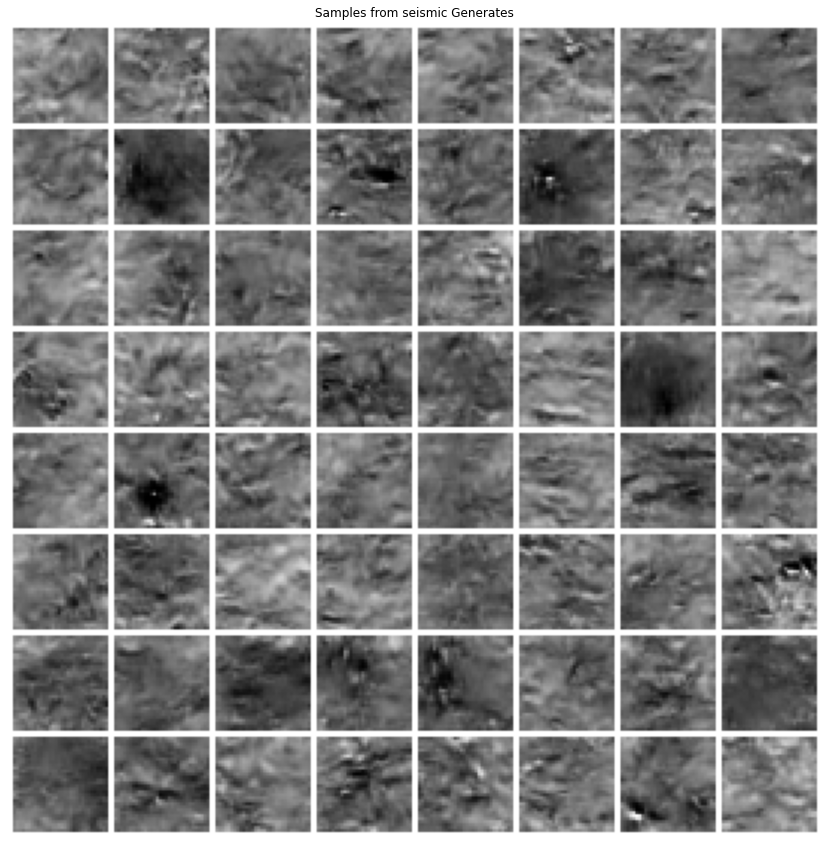

In [38]:
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(images_concat.cpu(),(1,2,0)),cmap='gray')
plt.axis('off')
plt.title('Samples from seismic Generates');
plt.show()

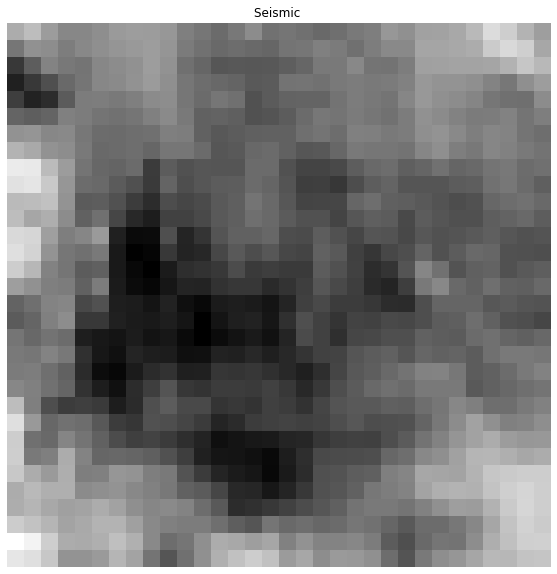

In [43]:
i=9
tensorImg = images[i][0].cpu()

plt.figure(figsize=(10,10))
plt.imshow(tensorImg, cmap='gray');  plt.axis('off')
plt.title("Seismic ")
plt.show()